In [1]:
# Import necessary libraries
import numpy as np 
import plotly.express as px 
import pandas as pd 
import cv2 
import os 
from glob import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import pickle 

In [2]:
# Combine data from all text files into a single DataFrame
df_list = []
for file_name in glob("AdienceBenchmark/*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)
del df_list

In [3]:
# Drop rows with missing values
df = df.dropna()

In [4]:
# Generate a full image path for each entry
df['image_path'] = df[['user_id', 'face_id', 'original_image']].apply(
    lambda x: os.path.join('AdienceBenchmark/faces', f"{x[0]}", f"coarse_tilt_aligned_face.{x[1]}.{x[2]}"), axis=1)

C:\Users\28455\AppData\Local\Temp\ipykernel_19096\2865205495.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: os.path.join('AdienceBenchmark/faces', f"{x[0]}", f"coarse_tilt_aligned_face.{x[1]}.{x[2]}"), axis=1)


In [5]:
# Map age labels to a consistent format
age_mapper = {'35': '(38, 48)','34': '(38, 48)','36': '(38, 48)','55':'(60, 100)','57':'(60, 100)','58':'(60, 100)','23':'(8, 23)','3':'(0, 2)','2':'(0, 2)'}
for elem in df[df['age'].str.startswith("(")]['age'].value_counts().index:
    age_mapper[elem] = elem
    
df['age'] = df['age'].map(age_mapper)

In [6]:
# Filter out entries with unspecified ages
df = df[df['age'] != 'None']
new_df = df[df['gender'] != 'u'][['age', 'gender', 'x', 'y', 'dx', 'dy','image_path']]

In [7]:
# Cleanup by deleting the original dataframe to free memory
del df

In [8]:
# Encode age labels as integers
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
new_df['age'] = le.fit_transform(new_df['age'])

In [9]:
# Save the encoder to disk for later use
with open('age_encoder.pkl','wb') as pkl_file:
    pickle.dump(le, pkl_file)

In [10]:
# Prepare data for training
X = new_df[['image_path']].values
y = new_df[['age']].values

# Generator function for yielding processed images and labels during training
def yield_training_values(X_train,y_train):
    for image_path, value in zip(X_train, y_train):
        image = preprocess_image(image_path)
        yield image, value 
        
# Helper function to load and preprocess images
def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    return img 

# Define image data augmentation steps
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2,0.2),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.Rescaling(1./255)
])

In [11]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [12]:
# Create TensorFlow data pipelines for training and testing
ds_train = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))


ds_test = tf.data.Dataset.from_generator(yield_training_values,
                                          args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))

In [13]:
# Set dataset parameters for optimal performance
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(buffer_size=100).batch(32).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().shuffle(buffer_size=100).batch(32).prefetch(buffer_size=AUTOTUNE)

In [14]:
# Define a CNN architecture
inputs = tf.keras.Input(shape = (128,128,3))
x = data_augmentation(inputs)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(13, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.models import Model
# 
# # Load pre-trained ResNet50 model without top layers
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# 
# # Freeze all layers except the last block
# for layer in base_model.layers[:-10]:
#     layer.trainable = False
# 
# # Add custom layers on top
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(512, activation='relu')(x)
# outputs = Dense(13, activation='softmax')(x)
# 
# # Create the complete model
# model = Model(inputs=base_model.input, outputs=outputs)

#Define a custom callback for logging loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        print(f"Epoch {epoch + 1}: loss = {logs.get('loss')}")

loss_history = LossHistory()

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Assuming you have the training data as `train_images` and `train_labels`
# model.fit(train_images, train_labels, epochs=10, callbacks=[loss_history, tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])


In [15]:
history = model.fit(ds_train, validation_data=ds_test,epochs=50)


Epoch 1/50
    464/Unknown 103s 218ms/step - accuracy: 0.1749 - loss: 2.7886

E:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


464/464 ━━━━━━━━━━━━━━━━━━━━ 117s 248ms/step - accuracy: 0.1750 - loss: 2.7880 - val_accuracy: 0.2731 - val_loss: 2.1617
Epoch 2/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 106s 229ms/step - accuracy: 0.2406 - loss: 2.2890 - val_accuracy: 0.2685 - val_loss: 2.2097
Epoch 3/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 107s 230ms/step - accuracy: 0.2519 - loss: 2.2133 - val_accuracy: 0.1295 - val_loss: 2.9332
Epoch 4/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 103s 222ms/step - accuracy: 0.2718 - loss: 2.1532 - val_accuracy: 0.1490 - val_loss: 2.8973
Epoch 5/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 103s 222ms/step - accuracy: 0.2749 - loss: 2.1191 - val_accuracy: 0.2391 - val_loss: 2.1989
Epoch 6/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 102s 219ms/step - accuracy: 0.2950 - loss: 2.0776 - val_accuracy: 0.2869 - val_loss: 2.1581
Epoch 7/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 104s 224ms/step - accuracy: 0.2990 - loss: 2.0360 - val_accuracy: 0.2956 - val_loss: 2.0295
Epoch 8/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 102s 220ms/step - accuracy: 0.3056 - loss: 2.00

In [19]:
# Save the trained model
model.save('mymodel.keras')

In [23]:
from tensorflow import keras
# Load the model for further training or inference
model = keras.models.load_model('mymodel.keras')
# Continue training if needed
model.fit(ds_train, validation_data=ds_test,epochs=50)


Epoch 1/50
    464/Unknown 110s 230ms/step - accuracy: 0.4650 - loss: 1.5031

E:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


464/464 ━━━━━━━━━━━━━━━━━━━━ 116s 243ms/step - accuracy: 0.4650 - loss: 1.5031 - val_accuracy: 0.4484 - val_loss: 1.5124
Epoch 2/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 114s 246ms/step - accuracy: 0.4735 - loss: 1.4835 - val_accuracy: 0.4561 - val_loss: 1.4945
Epoch 3/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 121s 260ms/step - accuracy: 0.4655 - loss: 1.5000 - val_accuracy: 0.4175 - val_loss: 1.6629
Epoch 4/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 126s 271ms/step - accuracy: 0.4703 - loss: 1.4861 - val_accuracy: 0.4351 - val_loss: 1.5802
Epoch 5/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 123s 264ms/step - accuracy: 0.4641 - loss: 1.4931 - val_accuracy: 0.4263 - val_loss: 1.5978
Epoch 6/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 116s 251ms/step - accuracy: 0.4634 - loss: 1.4901 - val_accuracy: 0.4759 - val_loss: 1.4642
Epoch 7/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 104s 224ms/step - accuracy: 0.4685 - loss: 1.4776 - val_accuracy: 0.4847 - val_loss: 1.4287
Epoch 8/50
464/464 ━━━━━━━━━━━━━━━━━━━━ 110s 236ms/step - accuracy: 0.4629 - loss: 1.47

In [26]:
model.save('100epoch.keras')

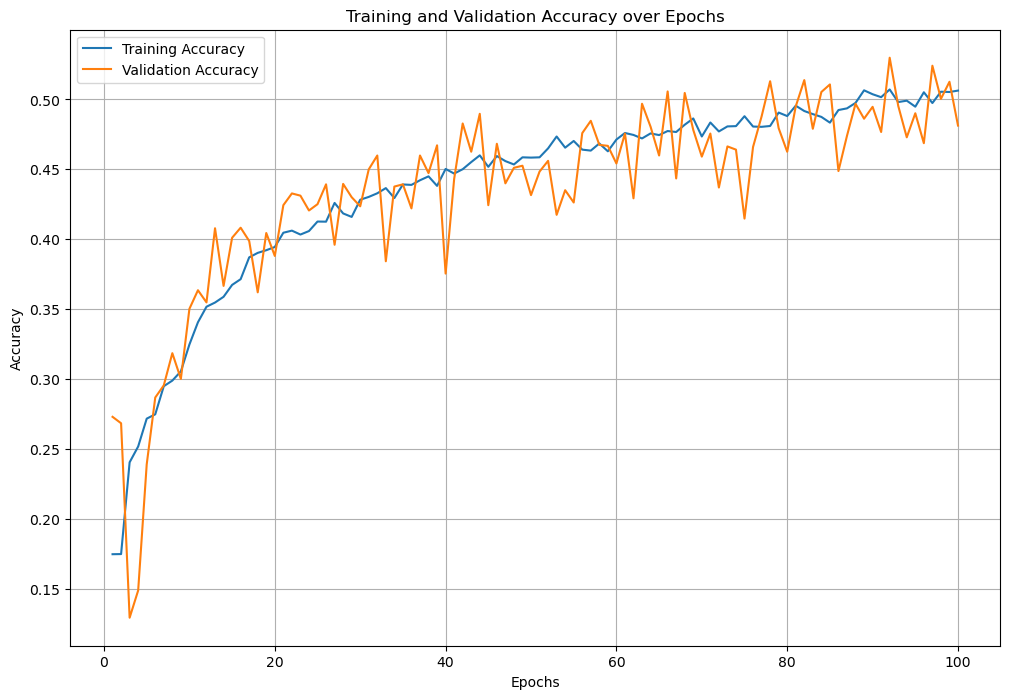

In [30]:
import matplotlib.pyplot as plt

# Data from training log
epochs = list(range(1, 101))
training_accuracy = [
    0.1749, 0.1750, 0.2406, 0.2519, 0.2718, 0.2749, 0.2950, 0.2990, 0.3056, 0.3248, 0.3407, 0.3518, 0.3548, 0.3589, 0.3674, 0.3715, 0.3871, 0.3903, 0.3922, 0.3945, 0.4047, 0.4062, 0.4034, 0.4059, 0.4127, 0.4126, 0.4260, 0.4185, 0.4160, 0.4283, 0.4303, 0.4329, 0.4366, 0.4295, 0.4392, 0.4389, 0.4422, 0.4450, 0.4382, 0.4503, 0.4470, 0.4501, 0.4552, 0.4600, 0.4518, 0.4595, 0.4559, 0.4535, 0.4586, 0.4584, 0.4586, 0.4650, 0.4735, 0.4655, 0.4703, 0.4641, 0.4634, 0.4685, 0.4629, 0.4713, 0.4760, 0.4746, 0.4721, 0.4757, 0.4745, 0.4774, 0.4767, 0.4819, 0.4864, 0.4735, 0.4835, 0.4771, 0.4807, 0.4809, 0.4880, 0.4806, 0.4804, 0.4810, 0.4906, 0.4881, 0.4955, 0.4917, 0.4895, 0.4875, 0.4834, 0.4924, 0.4936, 0.4975, 0.5065, 0.5037, 0.5016, 0.5071, 0.4981, 0.4991, 0.4948, 0.5051, 0.4974, 0.5055, 0.5053, 0.5063
]
val_accuracy = [
    0.2731, 0.2685, 0.1295, 0.1490, 0.2391, 0.2869, 0.2956, 0.3186, 0.3002, 0.3503, 0.3636, 0.3549, 0.4079, 0.3667, 0.4011, 0.4083, 0.3988, 0.3621, 0.4045, 0.3881, 0.4244, 0.4328, 0.4312, 0.4206, 0.4251, 0.4393, 0.3961, 0.4396, 0.4301, 0.4236, 0.4500, 0.4599, 0.3843, 0.4377, 0.4393, 0.4221, 0.4599, 0.4473, 0.4672, 0.3755, 0.4431, 0.4828, 0.4626, 0.4897, 0.4244, 0.4683, 0.4400, 0.4511, 0.4526, 0.4316, 0.4484, 0.4561, 0.4175, 0.4351, 0.4263, 0.4759, 0.4847, 0.4675, 0.4668, 0.4542, 0.4756, 0.4293, 0.4969, 0.4805, 0.4599, 0.5057, 0.4435, 0.5046, 0.4782, 0.4591, 0.4756, 0.4370, 0.4664, 0.4641, 0.4148, 0.4660, 0.4878, 0.5130, 0.4794, 0.4626, 0.4950, 0.5138, 0.4790, 0.5053, 0.5107, 0.4488, 0.4740, 0.4969, 0.4862, 0.4947, 0.4767, 0.5298, 0.4954, 0.4729, 0.4901, 0.4687, 0.5241, 0.5004, 0.5126, 0.4813
]

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

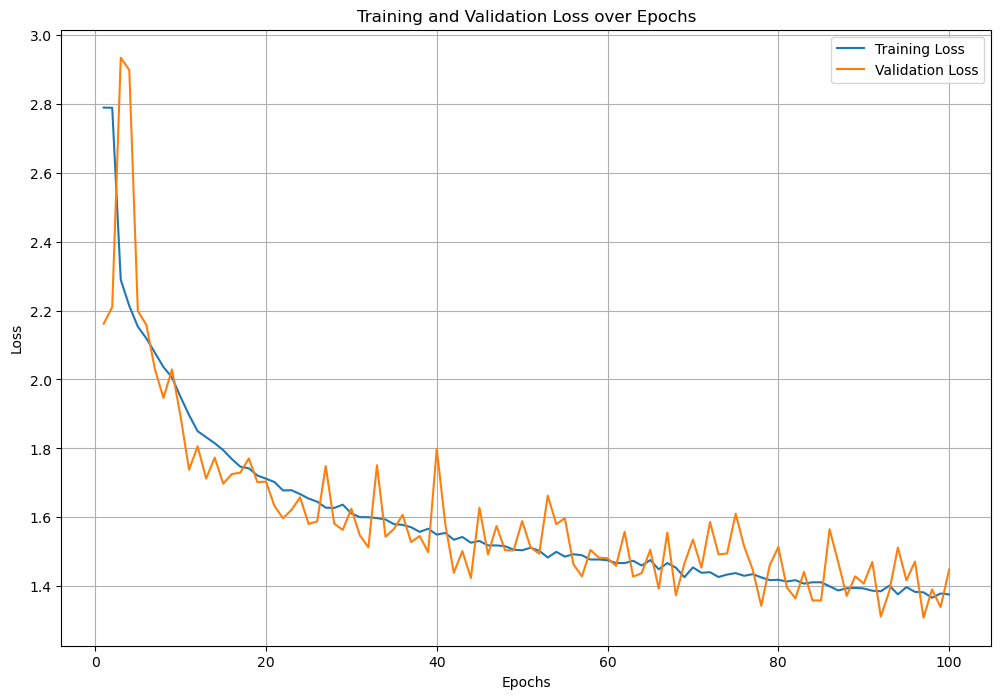

In [32]:
# Data for loss
training_loss = [
    2.7886, 2.7880, 2.2890, 2.2133, 2.1532, 2.1191, 2.0776, 2.0360, 2.0058, 1.9494, 1.8967, 1.8500, 1.8324, 1.8151, 1.7950, 1.7692, 1.7470, 1.7422, 1.7214, 1.7122, 1.7025, 1.6780, 1.6787, 1.6674, 1.6544, 1.6456, 1.6281, 1.6273, 1.6369, 1.6115, 1.6006, 1.6004, 1.5979, 1.5938, 1.5803, 1.5782, 1.5714, 1.5580, 1.5669, 1.5500, 1.5548, 1.5351, 1.5431, 1.5265, 1.5315, 1.5187, 1.5186, 1.5164, 1.5062, 1.5046, 1.5118, 1.5031, 1.4835, 1.5000, 1.4861, 1.4931, 1.4901, 1.4776, 1.4779, 1.4756, 1.4676, 1.4674, 1.4741, 1.4604, 1.4761, 1.4492, 1.4676, 1.4541, 1.4265, 1.4548, 1.4393, 1.4409, 1.4270, 1.4341, 1.4383, 1.4305, 1.4353, 1.4259, 1.4180, 1.4189, 1.4140, 1.4178, 1.4079, 1.4117, 1.4117, 1.4002, 1.3880, 1.3941, 1.3954, 1.3938, 1.3873, 1.3856, 1.4019, 1.3767, 1.3976, 1.3839, 1.3826, 1.3669, 1.3791, 1.3766
]
val_loss = [
    2.1617, 2.2097, 2.9332, 2.8973, 2.1989, 2.1581, 2.0295, 1.9463, 2.0291, 1.8933, 1.7381, 1.8062, 1.7124, 1.7733, 1.6976, 1.7255, 1.7298, 1.7709, 1.7021, 1.7039, 1.6330, 1.5973, 1.6219, 1.6581, 1.5807, 1.5884, 1.7487, 1.5814, 1.5638, 1.6253, 1.5475, 1.5131, 1.7512, 1.5437, 1.5668, 1.6073, 1.5284, 1.5458, 1.4991, 1.7985, 1.5806, 1.4392, 1.5023, 1.4241, 1.6279, 1.4921, 1.5749, 1.5046, 1.5042, 1.5892, 1.5124, 1.4945, 1.6629, 1.5802, 1.5978, 1.4642, 1.4287, 1.5053, 1.4829, 1.4814, 1.4593, 1.5581, 1.4280, 1.4383, 1.5059, 1.3928, 1.5560, 1.3740, 1.4661, 1.5354, 1.4541, 1.5866, 1.4926, 1.4952, 1.6108, 1.5156, 1.4484, 1.3433, 1.4616, 1.5139, 1.3968, 1.3650, 1.4420, 1.3590, 1.3588, 1.5657, 1.4710, 1.3722, 1.4290, 1.4078, 1.4706, 1.3120, 1.3864, 1.5125, 1.4175, 1.4718, 1.3089, 1.3910, 1.3395, 1.4483
]

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()